### Backtest Porfolio from Black–Litterman model for Asset Allocation - Backtrader

In [1]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import pandas_datareader.data as web
import pyfolio as pf
import backtrader as bt
idx = pd.IndexSlice

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
# Read our 20 tickers weights
wt_min_vola = pd.read_csv('data/wt_min_vola_wts.csv',  index_col=[0])
print(wt_min_vola)

                   0
ASIANPAINT  5.305046
AXISBANK    4.450531
BAJFINANCE  4.744928
BHARTIARTL  5.178707
HCLTECH     5.272667
HDFC        4.897932
HDFCBANK    5.088284
HINDUNILVR  5.464385
ICICIBANK   4.517027
INFY        5.294840
ITC         5.392489
KOTAKBANK   4.943356
LT          4.863501
MARUTI      5.016308
NESTLEIND   3.752084
RELIANCE    5.011075
SBIN        4.637817
SUNPHARMA   5.397222
TCS         5.382080
WIPRO       5.389720


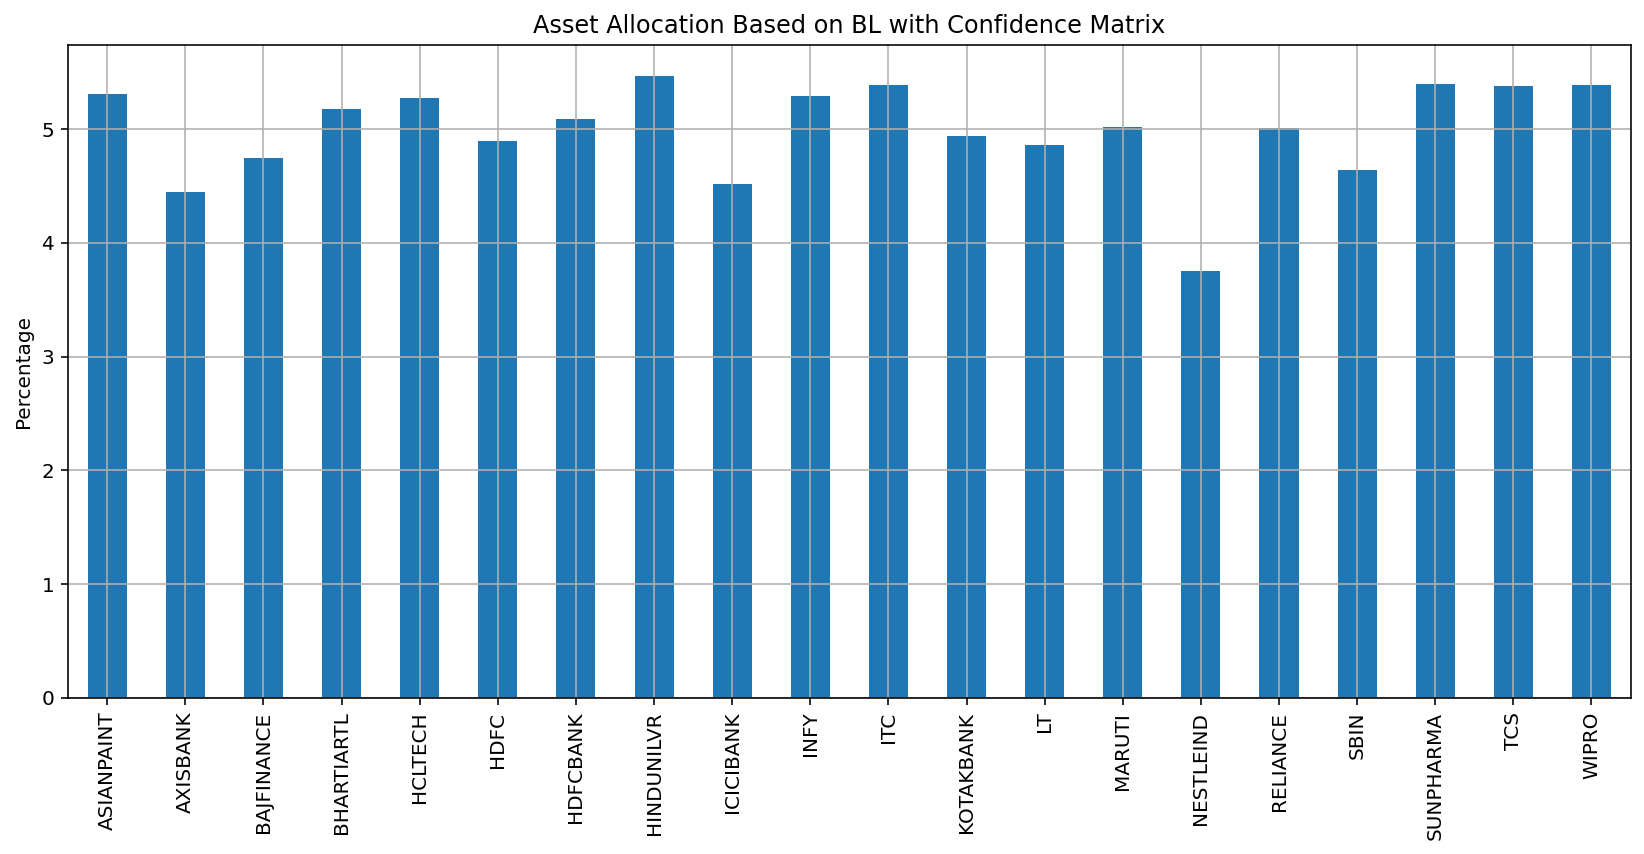

In [3]:
# plot the weights
wt_min_vola.plot.bar(figsize=(14,6), 
                    title = 'Asset Allocation Based on BL with Confidence Matrix', grid=True,legend=False);
plt.ylabel('Percentage')
plt.savefig('images/chart6', dpi=300)

In [4]:
# # data store path
# DATA_STORE = '../../../../machine-learning-for-trading-master/\
# machine-learning-for-trading-master/data/nse_asset.h5'

In [5]:
# with pd.HDFStore(DATA_STORE) as store:
#     print(store.info())

In [6]:
# # get the prices for top 20 companies
# with pd.HDFStore(DATA_STORE) as store:
#     prices = (store['/nse/nse500/prices'].loc[wt_min_vola.index])
# prices.head(2)

In [7]:
# # remove tickers where we have less than 10 years of data.
# min_obs = 2520
# nobs = prices.groupby(level='ticker').size()
# keep = nobs[nobs>min_obs].index

# prices = prices.loc[idx[keep,:], :]
# prices.info()

In [8]:
# date range for the backtesting
fromdate=datetime.datetime(2010, 1, 1)
todate=datetime.datetime(2020, 5, 29)

In [9]:
# # save the data as .csv file
# prices.to_csv('data/prices_all.csv')

In [10]:
# Read daily prices from csv
prices = pd.read_csv('data/prices_all.csv', index_col=['ticker','date'], parse_dates=True)
prices.head(2)

close  dividend       high        low       open  \
ticker     date                                                              
ASIANPAINT 2002-07-01  1.582765       0.0  22.466999  21.367001  21.367001   
           2002-07-02  1.599312       0.0  22.783001  21.370001  21.370001   

                       split    volume  
ticker     date                         
ASIANPAINT 2002-07-01    0.0   87810.0  
           2002-07-02    0.0  588615.0

In [11]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 101013 entries, (ASIANPAINT, 2002-07-01 00:00:00) to (WIPRO, 2020-06-18 00:00:00)
Data columns (total 7 columns):
close       101002 non-null float64
dividend    95926 non-null float64
high        101002 non-null float64
low         101002 non-null float64
open        101002 non-null float64
split       95926 non-null float64
volume      101002 non-null float64
dtypes: float64(7)
memory usage: 5.7+ MB


In [12]:
# create a tuple list of ticker and weight
assets_param = [(ind, wt_min_vola.loc[ind][0]) for ind in wt_min_vola.index]
print(assets_param)

[('ASIANPAINT', 5.3050460949855), ('AXISBANK', 4.45053090038327), ('BAJFINANCE', 4.744928182806199), ('BHARTIARTL', 5.17870712426497), ('HCLTECH', 5.2726673958685195), ('HDFC', 4.897932406597451), ('HDFCBANK', 5.0882842942980995), ('HINDUNILVR', 5.46438474485979), ('ICICIBANK', 4.5170274183420105), ('INFY', 5.29483981039163), ('ITC', 5.392489026751269), ('KOTAKBANK', 4.94335575111937), ('LT', 4.86350114073377), ('MARUTI', 5.01630787685359), ('NESTLEIND', 3.75208389044434), ('RELIANCE', 5.01107450303204), ('SBIN', 4.637816734784139), ('SUNPHARMA', 5.39722219405121), ('TCS', 5.3820803779708895), ('WIPRO', 5.38972013146196)]


In [13]:
# define the strategy
class Strategy(bt.Strategy):
    # parameters for inputs    
    params = dict(
        assets = [],
        rebalance_months = [1,3,6,9]
    )
 
    # initialize
    def __init__(self):
        # create a dictionary of ticker:{'rebalanced': False, 'target_percent': target%}
        self.rebalance_dict = dict()
        for i, d in enumerate(self.datas):
            self.rebalance_dict[d] = dict()
            self.rebalance_dict[d]['rebalanced'] = False
            for asset in self.p.assets:
                if asset[0] == d._name:
                    self.rebalance_dict[d]['target_percent'] = asset[1]
 
    def next(self):
        # rebalance for the month in the list
        for i, d in enumerate(self.datas):
            dt = d.datetime.datetime()
            dname = d._name
            pos = self.getposition(d).size
 
            if dt.month in self.p.rebalance_months and self.rebalance_dict[d]['rebalanced'] == False:
                print('{} Sending Order: {} | Month {} | Rebalanced: {} | Pos: {}'.
                      format(dt, dname, dt.month,
                             self.rebalance_dict[d]['rebalanced'], pos ))
            
                self.order_target_percent(d, target=self.rebalance_dict[d]['target_percent']/100)
                self.rebalance_dict[d]['rebalanced'] = True
 
            # Reset the flage
            if dt.month not in self.p.rebalance_months:
                self.rebalance_dict[d]['rebalanced'] = False
                
    # notify the order if completed
    def notify_order(self, order):
        date = self.data.datetime.datetime().date()
 
        if order.status == order.Completed:
            print('{} >> Order Completed >> Stock: {},  Ref: {}, Size: {}, Price: {}'.
                  format(date, order.data._name, order.ref, order.size,
                         'NA' if not order.price else round(order.price,5)
                        ))

    # notify the trade if completed        
    def notify_trade(self, trade):
        date = self.data.datetime.datetime().date()
        if trade.isclosed:
            print('{} >> Notify Trade >> Stock: {}, Close Price: {}, Profit, Gross {}, Net {}'.
                  format(date, trade.data._name, trade.price, round(trade.pnl,2),round(trade.pnlcomm,2))
                 )
            


In [14]:
# starting cash
startcash = 500000

# 0.4% commission
commission = 0.004

#Create an instance of cerebro
cerebro = bt.Cerebro()

cerebro.broker.setcash(startcash)

# orders will not be checked to see if you can afford it before submitting them
cerebro.broker.set_checksubmit(False)

cerebro.broker.setcommission(commission=commission)

In [15]:
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(TICKERS)

['ASIANPAINT', 'AXISBANK', 'BAJFINANCE', 'BHARTIARTL', 'HCLTECH', 'HDFC', 'HDFCBANK', 'HINDUNILVR', 'ICICIBANK', 'INFY', 'ITC', 'KOTAKBANK', 'LT', 'MARUTI', 'NESTLEIND', 'RELIANCE', 'SBIN', 'SUNPHARMA', 'TCS', 'WIPRO']


In [16]:
# load the data
for ticker, data in prices.groupby(level=0):
    if ticker in TICKERS:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ASIANPAINT
Adding ticker: AXISBANK
Adding ticker: BAJFINANCE
Adding ticker: BHARTIARTL
Adding ticker: HCLTECH
Adding ticker: HDFC
Adding ticker: HDFCBANK
Adding ticker: HINDUNILVR
Adding ticker: ICICIBANK
Adding ticker: INFY
Adding ticker: ITC
Adding ticker: KOTAKBANK
Adding ticker: LT
Adding ticker: MARUTI
Adding ticker: NESTLEIND
Adding ticker: RELIANCE
Adding ticker: SBIN
Adding ticker: SUNPHARMA
Adding ticker: TCS
Adding ticker: WIPRO


In [17]:
#Add our strategy
cerebro.addstrategy(Strategy, assets=assets_param)

# add analyzers
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [18]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. 
results = cerebro.run(stdstats=True, tradehistory=False)
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 500000.00
2010-01-04 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: KOTAKBANK | Month 1 |

2010-09-01 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 145
2010-09-01 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 90
2010-09-01 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 769
2010-09-01 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 82
2010-09-01 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 306
2010-09-01 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 33
2010-09-01 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 124
2010-09-01 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 99
2010-09-01 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 197
2010-09-01 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 135
2010-09-01 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 264
2010-09-01 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: False

2011-09-02 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 116
2011-09-02 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 113
2011-09-02 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 685
2011-09-02 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 76
2011-09-02 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 281
2011-09-02 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 34
2011-09-02 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 123
2011-09-02 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 100
2011-09-02 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 192
2011-09-02 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 158
2011-09-02 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 251
2011-09-02 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: Fal

2012-06-04 >> Order Completed >> Stock: ITC,  Ref: 181, Size: -32, Price: 129.12189
2012-06-04 >> Order Completed >> Stock: LT,  Ref: 182, Size: 4, Price: 422.70526
2012-06-04 >> Order Completed >> Stock: MARUTI,  Ref: 183, Size: 3, Price: 1001.32751
2012-06-04 >> Order Completed >> Stock: RELIANCE,  Ref: 184, Size: 9, Price: 309.0137
2012-06-04 >> Order Completed >> Stock: SUNPHARMA,  Ref: 186, Size: -4, Price: 271.50446
2012-06-04 >> Order Completed >> Stock: TCS,  Ref: 187, Size: -1, Price: 482.81024
2012-06-04 >> Order Completed >> Stock: WIPRO,  Ref: 188, Size: 8, Price: 117.13297
2012-09-03 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 91
2012-09-03 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 148
2012-09-03 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 447
2012-09-03 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 100
2012-09-03 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalan

2013-09-02 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 91
2013-09-02 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 129
2013-09-02 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 300
2013-09-02 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 138
2013-09-02 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 257
2013-09-02 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 40
2013-09-02 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 115
2013-09-02 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 75
2013-09-02 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 201
2013-09-02 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 198
2013-09-02 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 197
2013-09-02 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: Fals

2015-01-01 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 101
2015-01-01 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 129
2015-01-01 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 243
2015-01-01 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 178
2015-01-01 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 179
2015-01-01 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 53
2015-01-01 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 146
2015-01-01 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 92
2015-01-01 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 194
2015-01-01 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 189
2015-01-01 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 273
2015-01-01 00:00:00 Sending Order: KOTAKBANK | Month 1 | Rebalanced: Fal

2015-09-01 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 139
2015-09-01 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 90
2015-09-01 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 228
2015-09-01 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 183
2015-09-01 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 366
2015-09-01 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: False | Pos: 97
2015-09-01 00:00:00 Sending Order: LT | Month 9 | Rebalanced: False | Pos: 64
2015-09-01 00:00:00 Sending Order: MARUTI | Month 9 | Rebalanced: False | Pos: 19
2015-09-01 00:00:00 Sending Order: NESTLEIND | Month 9 | Rebalanced: False | Pos: 8
2015-09-01 00:00:00 Sending Order: RELIANCE | Month 9 | Rebalanced: False | Pos: 156
2015-09-01 00:00:00 Sending Order: SBIN | Month 9 | Rebalanced: False | Pos: 229
2015-09-01 00:00:00 Sending Order: SUNPHARMA | Month 9 | Rebalanced: False | Pos: 85
20

2016-06-02 >> Order Completed >> Stock: INFY,  Ref: 460, Size: 1, Price: 533.95374
2016-06-02 >> Order Completed >> Stock: ITC,  Ref: 461, Size: -3, Price: 228.52257
2016-06-02 >> Order Completed >> Stock: KOTAKBANK,  Ref: 462, Size: -2, Price: 743.62231
2016-06-02 >> Order Completed >> Stock: LT,  Ref: 463, Size: -11, Price: 899.6731
2016-06-02 >> Order Completed >> Stock: RELIANCE,  Ref: 464, Size: 18, Price: 467.92096
2016-06-02 >> Order Completed >> Stock: SBIN,  Ref: 465, Size: 56, Price: 193.92604
2016-06-02 >> Order Completed >> Stock: TCS,  Ref: 467, Size: -1, Price: 1175.86743
2016-06-02 >> Order Completed >> Stock: WIPRO,  Ref: 468, Size: 31, Price: 202.47322
2016-09-01 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 76
2016-09-01 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 125
2016-09-01 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 89
2016-09-01 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalan

2017-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 82
2017-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 136
2017-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 69
2017-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 248
2017-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 200
2017-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 55
2017-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 117
2017-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 101
2017-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 288
2017-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 180
2017-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 330
2017-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2018-09-03 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 85
2018-09-03 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 168
2018-09-03 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 47
2018-09-03 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 303
2018-09-03 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 220
2018-09-03 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 54
2018-09-03 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 99
2018-09-03 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 72
2018-09-03 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 324
2018-09-03 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 190
2018-09-03 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 414
2018-09-03 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: False 

2020-01-01 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 81
2020-01-01 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 163
2020-01-01 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 35
2020-01-01 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 364
2020-01-01 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 227
2020-01-01 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 56
2020-01-01 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 108
2020-01-01 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 71
2020-01-01 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 272
2020-01-01 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 160
2020-01-01 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 528
2020-01-01 00:00:00 Sending Order: KOTAKBANK | Month 1 | Rebalanced: False

In [19]:
# Extract inputs for pyfolio
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [20]:
# Extract inputs for pyfolio
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2010-01-04 00:00:00+00:00    0.000000
2010-01-05 00:00:00+00:00   -0.307223
Name: Strategy, dtype: float64

In [21]:
# Get the benchmark returns for comparison
benchmark = '^BSESN' # S&P BSE Sensex
benchmark_rets= web.DataReader(benchmark, 'yahoo', start='2010-01-01',)['Adj Close'].pct_change().dropna()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'S&P BSE-SENSEX'
benchmark_rets.head(2)

Date
2010-01-05 00:00:00+00:00    0.007262
2010-01-06 00:00:00+00:00    0.000842
Name: S&P BSE-SENSEX, dtype: float64

In [22]:
# Get the benchmark prices for comparison
benchmark = '^BSESN' # S&P BSE Sensex
benchmark_prices = web.DataReader(benchmark, 'yahoo', start='2010-01-01',)['Adj Close']
benchmark_prices = benchmark_prices.asfreq('D', method='ffill')
benchmark_prices.index = benchmark_prices.index.tz_localize('UTC')
benchmark_prices = benchmark_prices.filter(returns.index)
benchmark_prices.head(5)

Date
2010-01-04 00:00:00+00:00    17558.730469
2010-01-05 00:00:00+00:00    17686.240234
2010-01-06 00:00:00+00:00    17701.130859
2010-01-07 00:00:00+00:00    17615.720703
2010-01-08 00:00:00+00:00    17540.289062
Name: Adj Close, dtype: float64

In [23]:
# Rebase the benchmark prices for comparison
benchmark_prices = (benchmark_prices/benchmark_prices.iloc[0]) * startcash
benchmark_prices.head()

Date
2010-01-04 00:00:00+00:00    500000.000000
2010-01-05 00:00:00+00:00    503630.950593
2010-01-06 00:00:00+00:00    504054.973988
2010-01-07 00:00:00+00:00    501622.846096
2010-01-08 00:00:00+00:00    499474.865046
Name: Adj Close, dtype: float64

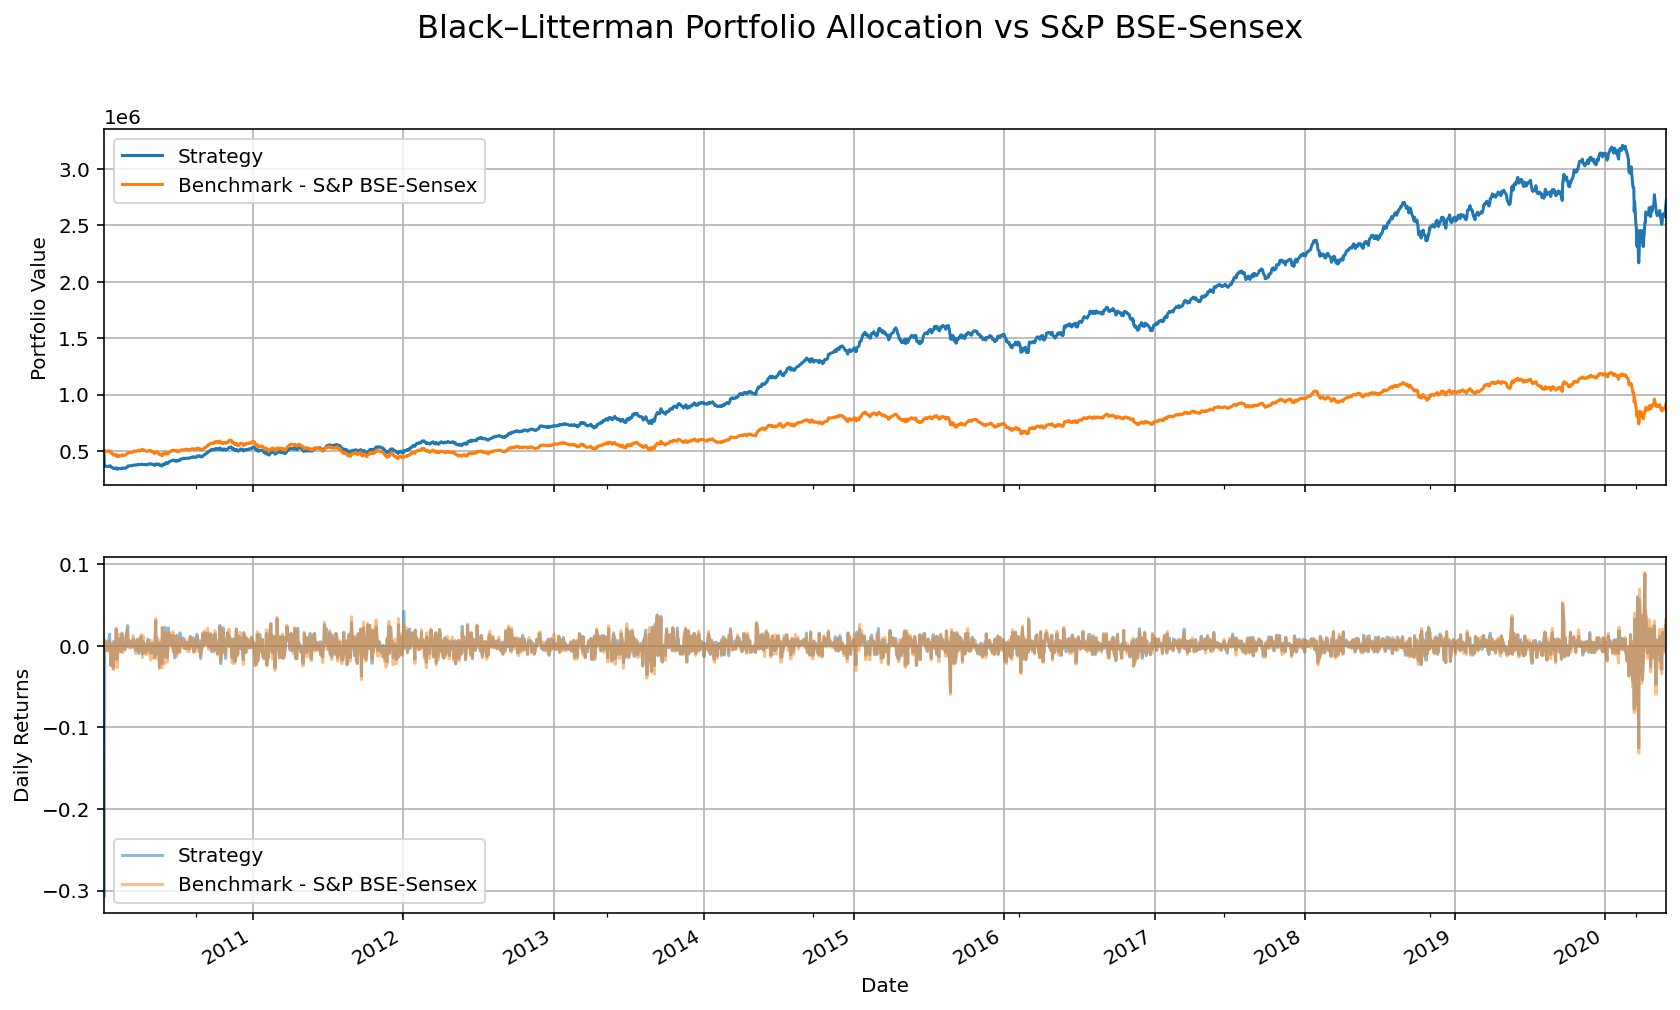

In [30]:
portfolio_value = returns.cumsum().apply(np.exp) * startcash

# Visulize the output
fig, ax = plt.subplots(2, 1, sharex=True, figsize=[14, 8])

# portfolio value
portfolio_value.plot(ax=ax[0], label='Strategy')
benchmark_prices.plot(ax=ax[0], label='Benchmark - S&P BSE-Sensex')
ax[0].set_ylabel('Portfolio Value')
ax[0].grid(True)
ax[0].legend()

# daily returns
returns.plot(ax=ax[1], label='Strategy', alpha=0.5)
benchmark_rets.plot(ax=ax[1], label='Benchmark - S&P BSE-Sensex', alpha=0.5)
ax[1].set_ylabel('Daily Returns')

fig.suptitle('Black–Litterman Portfolio Allocation vs S&P BSE-Sensex', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('images/chart9', dpi=300)

In [25]:
import seaborn as sns
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [26]:
# get performance statistics for strategy
pf.show_perf_stats(returns,)

In [27]:
# get performance statistics for benchmark
pf.show_perf_stats(benchmark_rets)

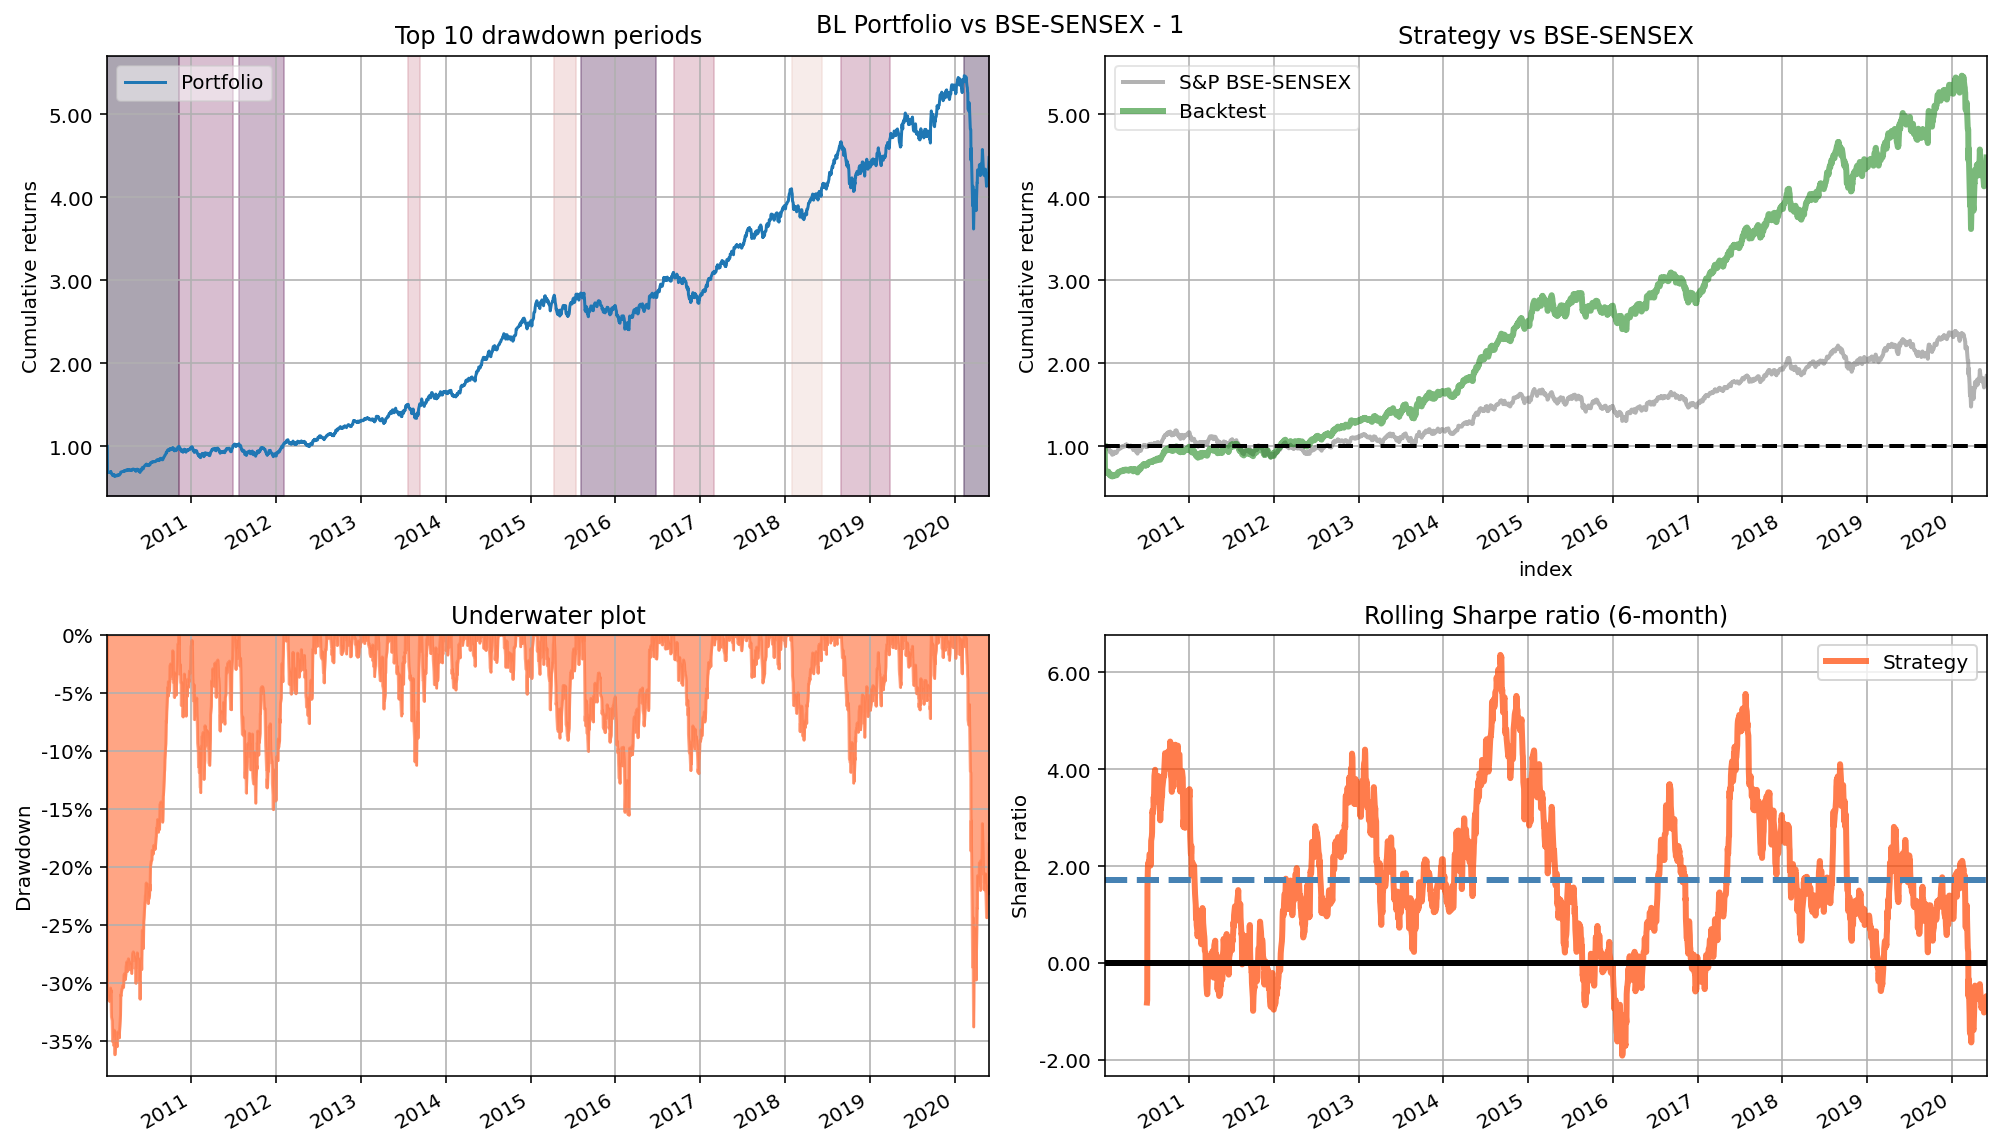

In [28]:
# plot performance for strategy
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs BSE-SENSEX')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
fig.suptitle('BL Portfolio vs BSE-SENSEX - 1', fontsize=12, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart7', dpi=300)

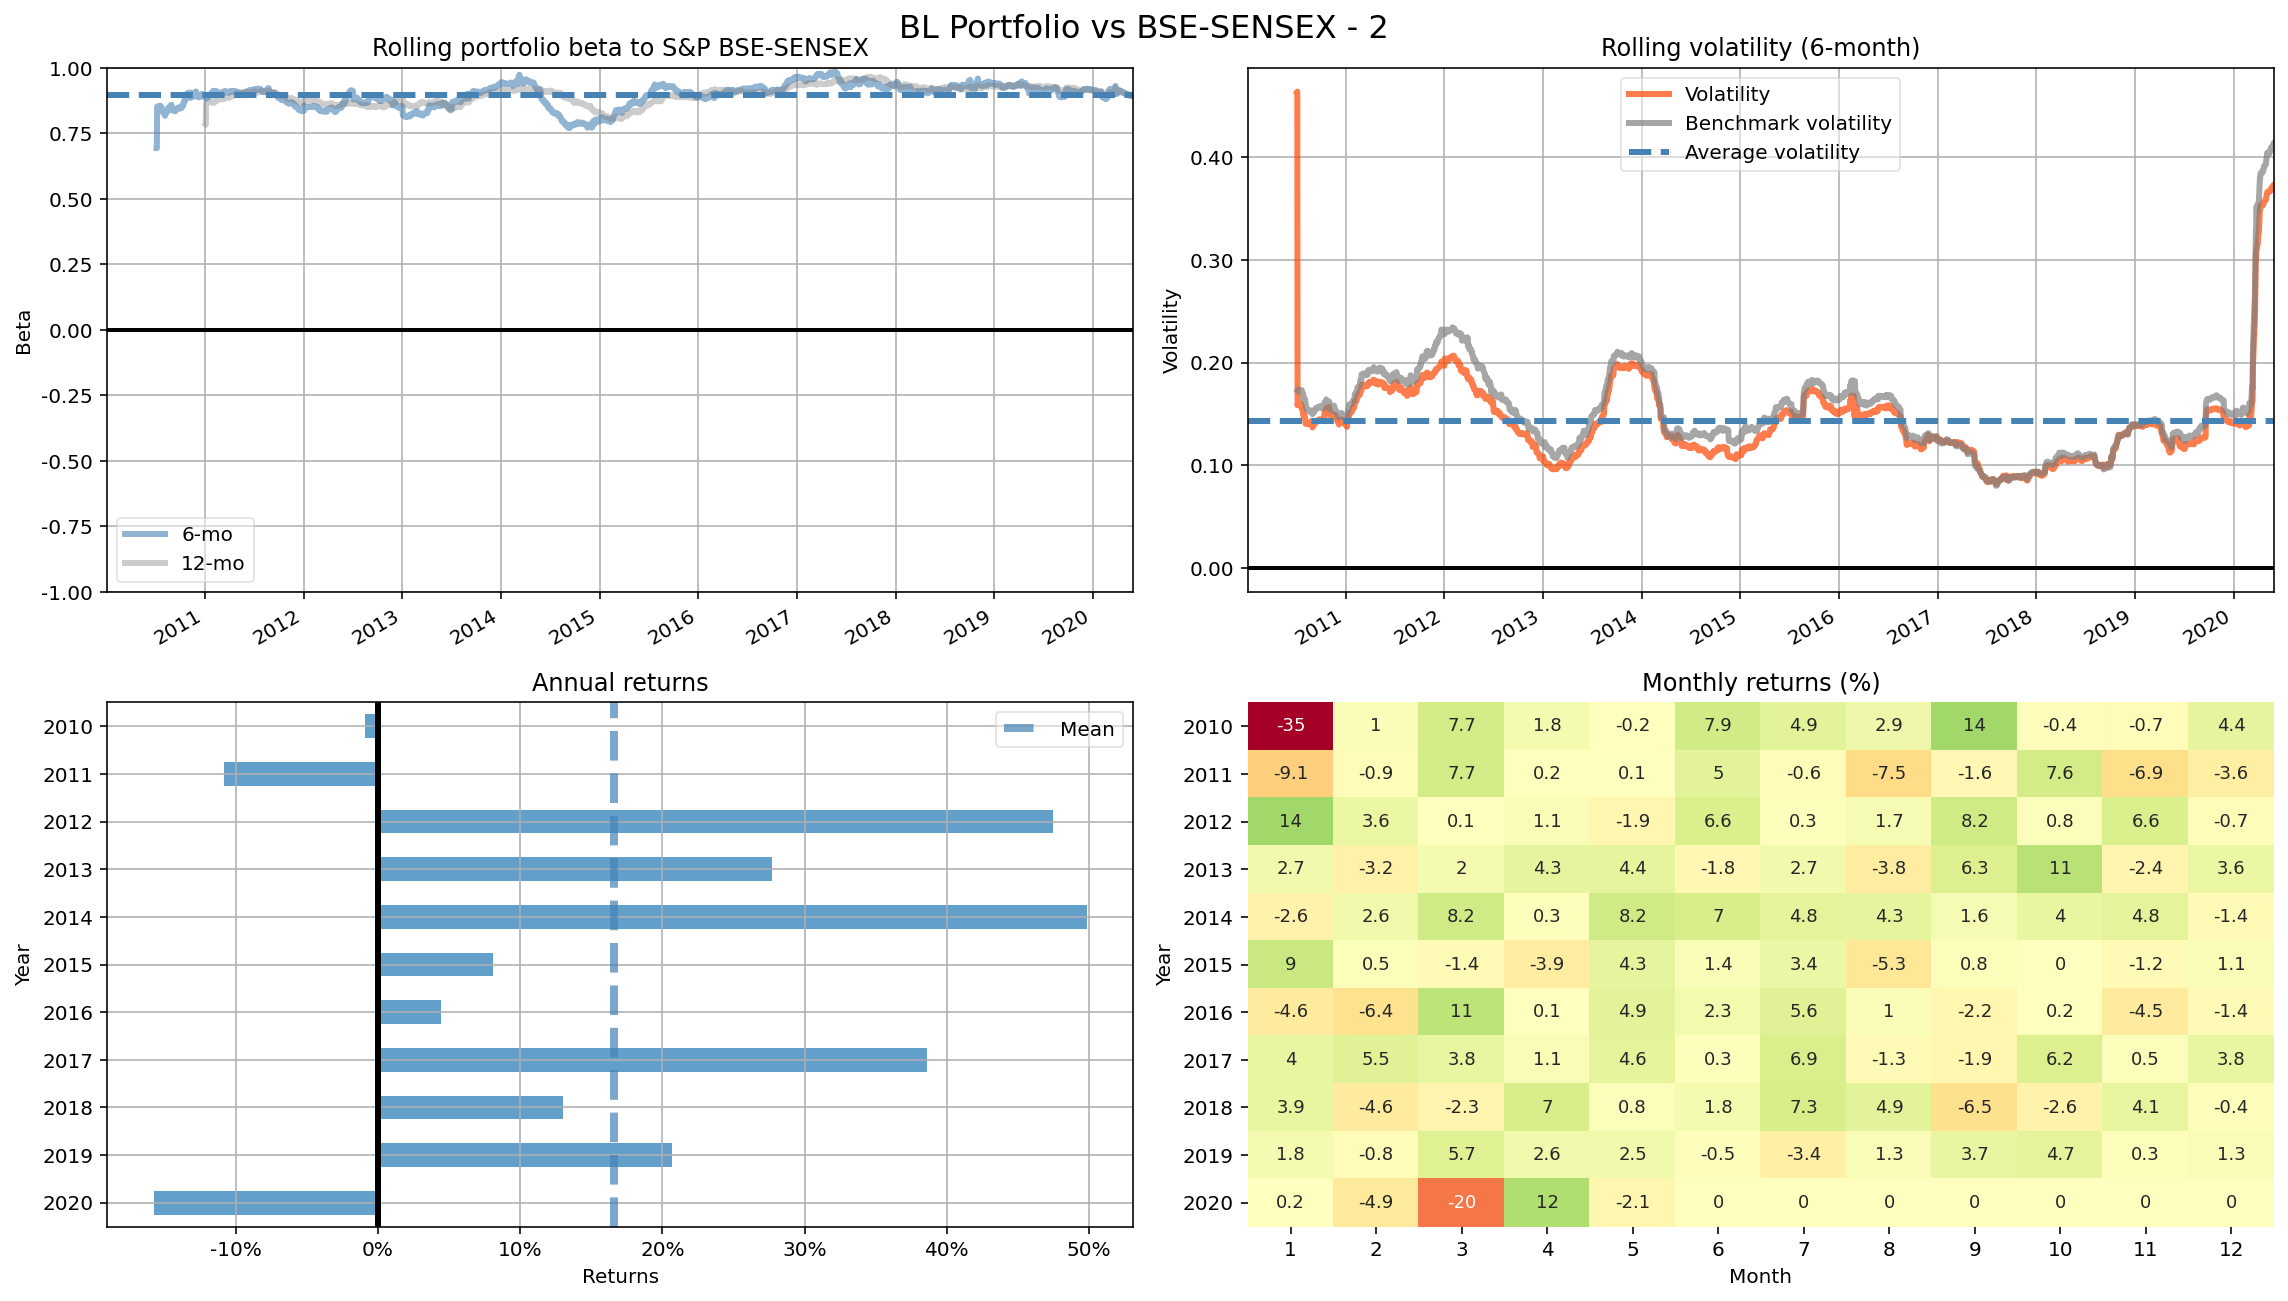

In [29]:
# plot performance
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig('images/chart8', dpi=300)